In [1]:
import json
import numpy as np
import glob
from pandas import DataFrame as df

exps = glob.glob('results/ds_1.0/*')
# exps = glob.glob('results/ds_0.25/*')  # for downsampled

results = {}
for exp in exps:
    files = glob.glob(exp+'/*')
    exp_name = exp.split('/')[-1]
    results[exp_name] = []
    for file in files:
        with open(file, 'r') as f:
            results[exp_name].append(json.load(f))

success_rate = {'problem': [], 'lexicase': [], 'lexiprob-1.0': [],
                'lexiprob-2.0': [], 'lexiprob-0.5': []}

for exp in sorted(results.keys()):
    success = sum([i['test_err'] == 0 for i in results[exp]])
    total = len(results[exp])

    method = exp.split('-')[-1]
    if method in ['lexicase', 'lexiprob']:
        problem_name = '-'.join(exp.split('-')[:-1])
        success_rate[method].append(success)
        if problem_name not in success_rate['problem']:
            success_rate['problem'].append(problem_name)
    else:
        method = '-'.join(exp.split('-')[-2:])
        problem_name = '-'.join(exp.split('-')[:-2])
        success_rate[method].append(success)
        if problem_name not in success_rate['problem']:
            success_rate['problem'].append(problem_name)

lexicase_runtime = {}
lexiprob_runtime = {}

for exp in sorted(results):
    if str(exp)[-12:] == 'lexiprob-1.0':
        lexicase_runtime[str(exp)[:-13]] = []
        lexiprob_runtime[str(exp)[:-13]] = []
        for i in results[exp]:
            if len(i['lexiprob_runtime']) > 0:
                lexicase_runtime[str(exp)[:-13]].append(np.mean(i['lexicase_runtime']))
                lexiprob_runtime[str(exp)[:-13]].append(np.mean(i['lexiprob_runtime']))

per_generation_speed_up = {}
for exp in lexicase_runtime:
    per_generation_speed_up[exp] = [np.mean(lexicase_runtime[exp])/np.mean(lexiprob_runtime[exp])]

print('success rate')
print(df(success_rate))
print()
print('per generation speed up')
print(df(per_generation_speed_up))


success rate
          problem  lexicase  lexiprob-1.0  lexiprob-2.0  lexiprob-0.5
0             csl         0             0             0             0
1          median        89            83            96            61
2             ntz        79            80            70            85
3       number-io        99           100           100            99
4            rswn        10             6            13             4
5        smallest       100           100           100            98
6  vector-average       100            99           100           100

per generation speed up
        csl    median       ntz  number-io      rswn  smallest  vector-average
0  3.316737  3.773108  8.647413   6.534033  1.472477  6.220157        3.946565


In [2]:
import json
import numpy as np
import glob
from matplotlib import pyplot as plt
from pandas import DataFrame as df

exps = glob.glob('results/ds_1.0/*')

results = {}
for exp in exps:
    files = glob.glob(exp+'/*')
    exp_name = exp.split('/')[-1]
    results[exp_name] = []
    for file in files:
        with open(file, 'r') as f:
            results[exp_name].append(json.load(f))

overlap = {'Problem': [], 'Overlap Ratio': [], 'Category': []}

for exp in sorted(results.keys()):
    method = exp.split('-')[-1]
    if method in ['lexicase', '2.0', '0.5']:
        continue
    else:
        method = '-'.join(exp.split('-')[-2:])
        problem_name = '-'.join(exp.split('-')[:-2])
        if problem_name == 'csl':
            problem_name = 'compare-string-lengths'
        if problem_name == 'ntz':
            problem_name = 'negative-to-zero'
        if problem_name == 'rswn':
            problem_name = 'replace-space-with-newline'

        re1 = [[j[0]/j[1] for j in i['total_overlap']] for i in results[exp]]
        re2 = [[j[0]/j[1] for j in i['unique_overlap']] for i in results[exp]]

        for r1, r2 in zip(re1, re2):
            if len(r1) > 0:
                overlap['Overlap Ratio'].append(np.mean(r1))
                overlap['Category'].append('All Individuals')
                overlap['Problem'].append(problem_name)

                overlap['Overlap Ratio'].append(np.mean(r2))
                overlap['Category'].append('Unique Individuals')
                overlap['Problem'].append(problem_name)


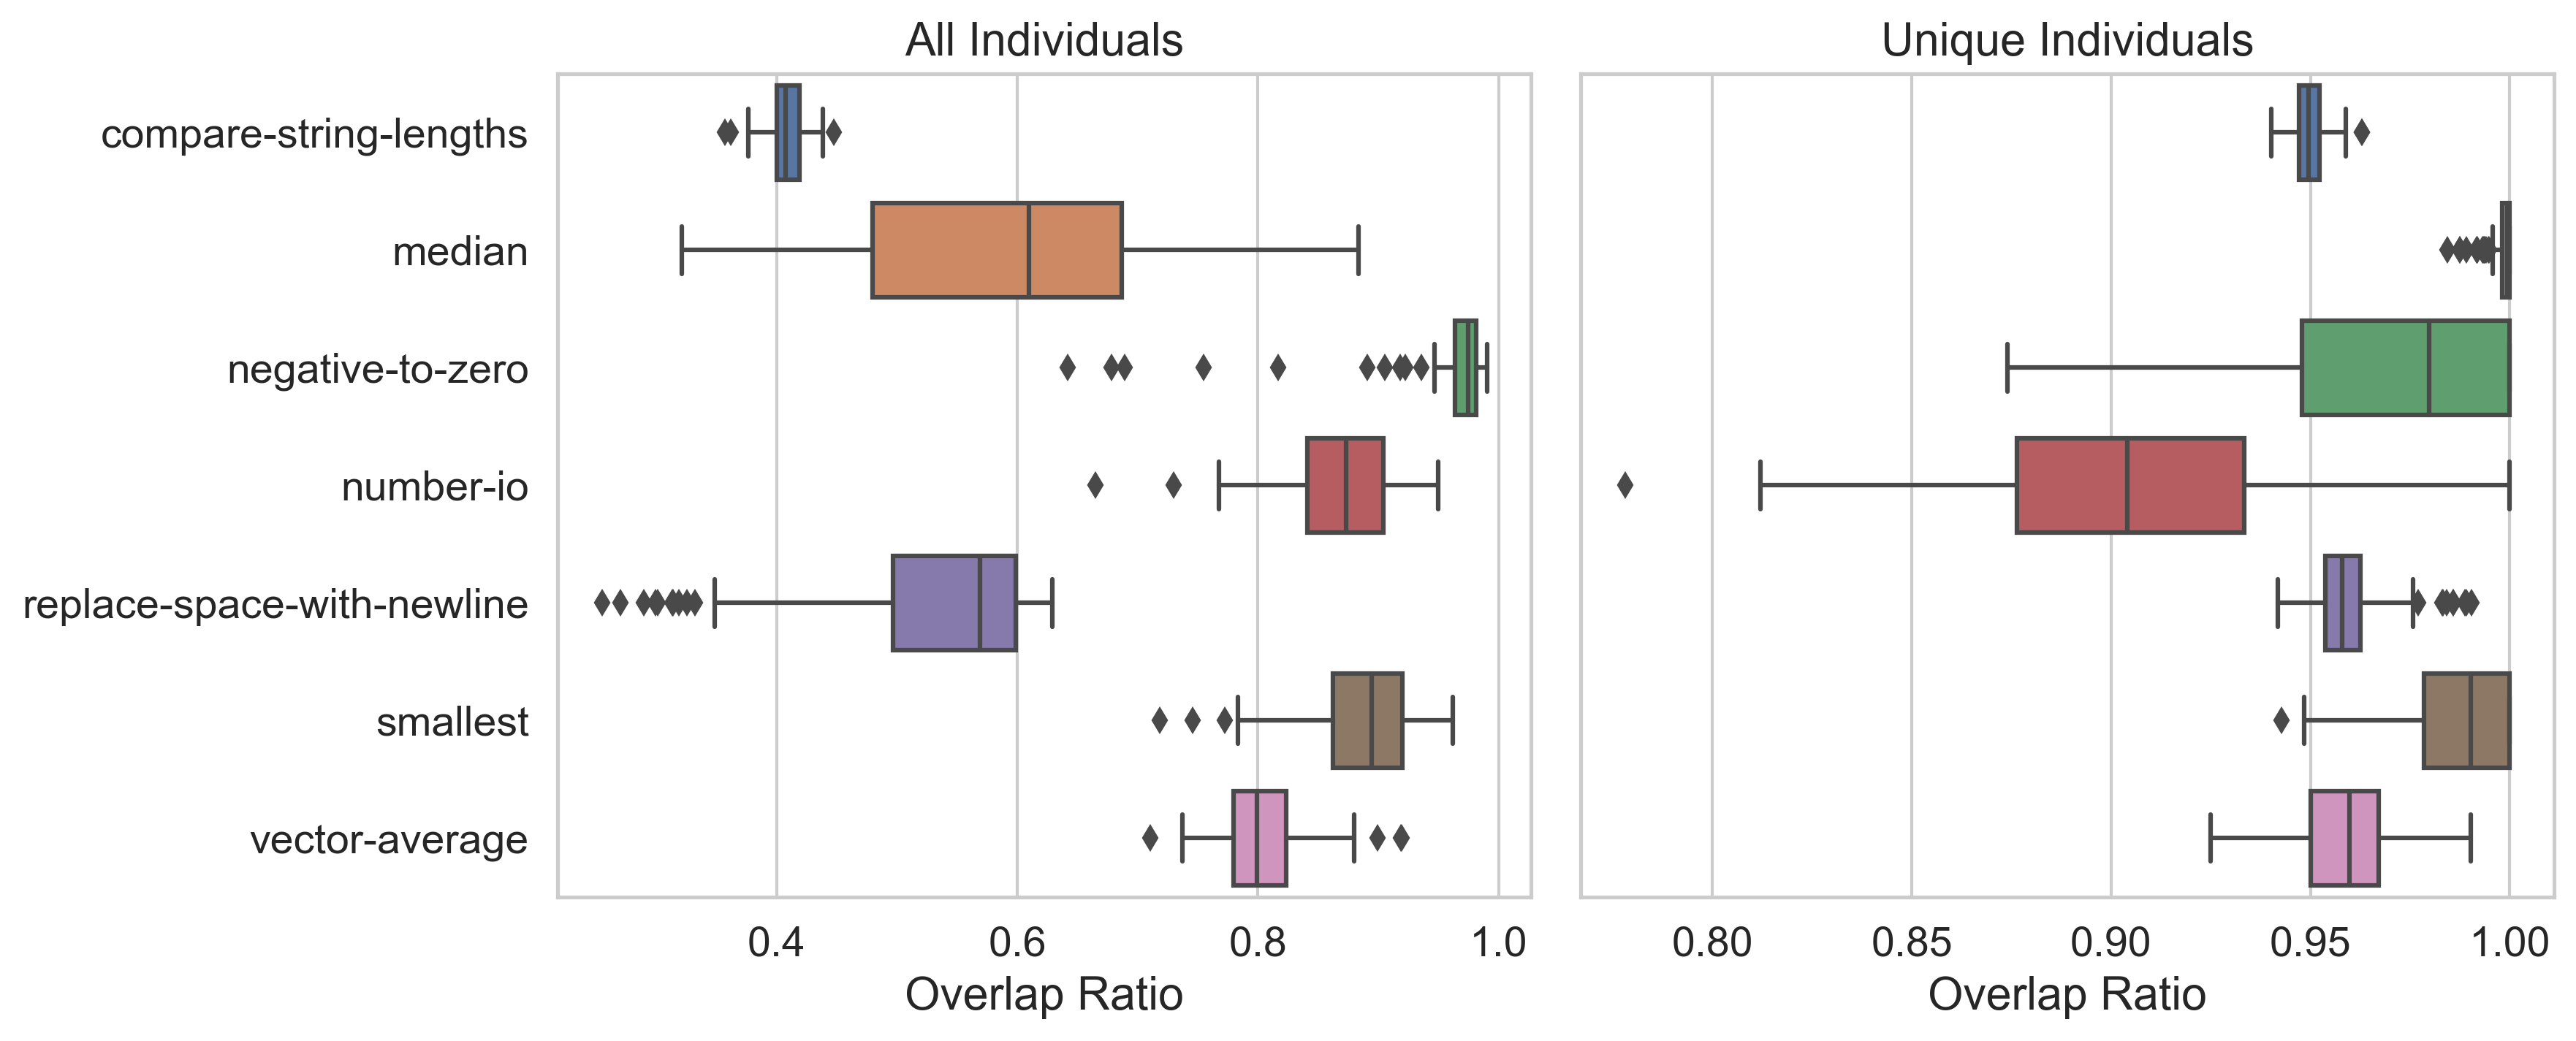

In [3]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale=1.25, style='whitegrid')
d = df(overlap)

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=False, sharey=True, dpi=300)

sns.boxplot(data=d[d['Category']=='All Individuals'], x='Overlap Ratio', y='Problem', ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_title('All Individuals')
sns.boxplot(data=d[d['Category']=='Unique Individuals'], x='Overlap Ratio', y='Problem', ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_title('Unique Individuals')

plt.tight_layout()
plt.savefig('overlap.pdf', bbox_inches='tight', dpi=300)
